In [1]:
from typing import OrderedDict
from pathlib import Path
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import torch
from torch.nn import ReLU, Sigmoid, MSELoss
from torch.utils.data import DataLoader
from MulticoreTSNE import MulticoreTSNE as TSNE
from functools import partial
import datashader as ds
import datashader.transfer_functions as dtf
from datashader.mpl_ext import dsshow
import pandas as pd

from py.datasets.euromds import CachedEUROMDS
from py.dec.torch.sdae import StackedDenoisingAutoEncoder
from py.dec.torch.dec import DEC
from py.dec.torch.utils import get_linears
from py.dec.torch.utils import cluster_accuracy

In [2]:
PATH_TO_DATA = Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project/data/euromds')
PATH_TO_MODELS = Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project/results/')
ae_params_filename = 'agg_weights_pretrain_ae.npz'
dec_params_filename = 'agg_weights_dec.npz'
centroid_multi_filename = 'centroids_multi.csv'
distributions = ['unif', 'skew4']
optmizers = ['fedavg', 'fedadam', 'fedyogi']
centroids_aggregators = ['max_min', 'random', 'random_weighted', 'double_kmeans']
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda:0"
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

Load data

In [3]:
dataset = CachedEUROMDS(
        exclude_cols=['UTX', 'CSF3R', 'SETBP1', 'PPM1D'],
        groups=['Genetics', 'CNA'],
        path_to_data=PATH_TO_DATA,
        fill_nans=2044,
        get_hdp=True,
        get_outcomes=True,
        get_ids=True,
        verbose=False,
        device=DEVICE,
    )
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
)

Load models

In [4]:
autoencoder = StackedDenoisingAutoEncoder(
    get_linears('dec', dataset.n_features, 10),
    activation=ReLU(),
    final_activation=ReLU(),
    dropout=0.0,
    is_tied=True,
)
autoencoder.to(DEVICE)
model = DEC(cluster_number=6,
            hidden_dimension=10,
            encoder=autoencoder.encoder,
            alpha=1)
model.to(DEVICE)

DEC(
  (encoder): Sequential(
    (0): Sequential(
      (linear): Linear(in_features=54, out_features=500, bias=True)
      (activation): ReLU()
    )
    (1): Sequential(
      (linear): Linear(in_features=500, out_features=500, bias=True)
      (activation): ReLU()
    )
    (2): Sequential(
      (linear): Linear(in_features=500, out_features=2000, bias=True)
      (activation): ReLU()
    )
    (3): Sequential(
      (linear): Linear(in_features=2000, out_features=10, bias=True)
    )
  )
  (assignment): ClusterAssignment()
)

Evaluate initial TSDAE parameters, before clustering step.

In [5]:
ae_losses = []
for d in distributions:
    for opt in optmizers:
        for agg in centroids_aggregators:
            current_path = PATH_TO_MODELS/'feuromds_{}_{}_{}'. \
                format(d, opt, agg)
            if current_path.exists():
                # get pretrain param
                ae_parameters = np.load(
                    current_path/ae_params_filename,
                    allow_pickle=True)
                ae_parameters = [ae_parameters[a] for a in ae_parameters][0]
                params_dict = zip(autoencoder.state_dict().keys(), ae_parameters)
                state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
                autoencoder.load_state_dict(state_dict, strict=True)
                # eval pretraining
                cl_recon = 0.0
                data = []
                r_data = []
                criterion = MSELoss()
                autoencoder.eval()
                for i, batch in enumerate(dataloader):
                    with torch.no_grad():
                        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
                            batch, value = batch
                            batch = batch.to(DEVICE, non_blocking=True)
                            r_batch = autoencoder(batch)
                            data.append(batch.cpu())
                            r_data.append(r_batch.cpu())
                            loss = criterion(r_batch, batch)
                            cl_recon += loss.cpu().numpy()
                cl_recon = (cl_recon / (i+1))
                print('Reconstruction loss is {}'.format(cl_recon))
                ae_losses.append(cl_recon)
                r_data = torch.cat(r_data).numpy()
                data = torch.cat(data).numpy()
                # show fig of data and reconstruction
                fig, axs = plt.subplots(1, 5, figsize=(8, 8))
                ids = [3, 4, 345, 58, 34]
                axs = axs.flatten()
                for i, ax in zip(ids, axs):
                    ax.imshow(r_data[i].reshape((6, 9)),
                            interpolation='none', cmap='gray')
                    ax.axis('off')
                plt.savefig(current_path/'pretrain_recon_imgs.png')
                plt.close()
                fig, axs = plt.subplots(1, 5, figsize=(8, 8))
                ids = [3, 4, 345, 58, 34]
                axs = axs.flatten()
                for i, ax in zip(ids, axs):
                    ax.imshow(data[i].reshape((6, 9)),
                            interpolation='none', cmap='gray')
                    ax.axis('off')
                plt.savefig(current_path/'pretrain_real_imgs.png')
                plt.close()
                # showing scatterplot matrix of centroids
                figure, ax = plt.subplots(1, 1, figsize=(40,40))
                pd.plotting.scatter_matrix(pd.read_csv(current_path/centroid_multi_filename), ax=ax, grid=True)
                plt.savefig(current_path/'scat_matrix_centroids.png')
                plt.close()

Reconstruction loss is 0.02036761929412023


/tmp/ipykernel_55357/4274597982.py:58: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(pd.read_csv(current_path/centroid_multi_filename), ax=ax, grid=True)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Reconstruction loss is 0.020291340562380356
Reconstruction loss is 0.02013157522628717
Reconstruction loss is 0.02011373294317309
Reconstruction loss is 0.021545521793086664
Reconstruction loss is 0.02141946729625488
Reconstruction loss is 0.0214983926516652
Reconstruction loss is 0.021438667012262158
Reconstruction loss is 0.017522469371385796
Reconstruction loss is 0.017435802936887512
Reconstruction loss is 0.017498810580406143
Reconstruction loss is 0.01755995342858796
Reconstruction loss is 0.02120571851924069
Reconstruction loss is 0.0214905903448539
Reconstruction loss is 0.020962634837928817
Reconstruction loss is 0.021171491851418978
Reconstruction loss is 0.01533563691737072
Reconstruction loss is 0.015225133700369042
Reconstruction loss is 0.015143509705922042
Reconstruction loss is 0.015228880361064512
Reconstruction loss is 0.015302566038116083
Reconstruction loss is 0.0154596787925243
Reconstruction loss is 0.015373411575637874
Reconstruction loss is 0.015391156943564965


Feature space representation.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


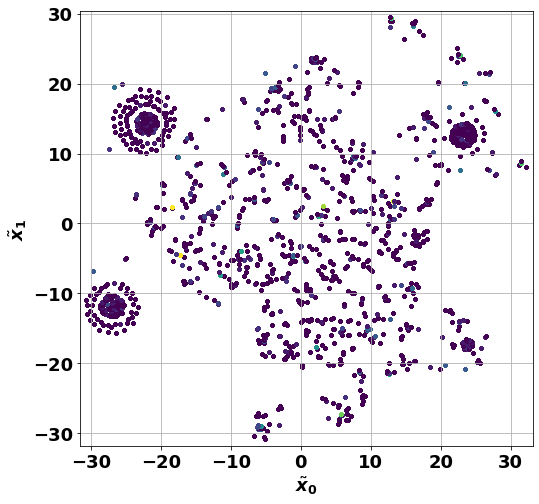

In [6]:
result_folder = 'feuromds_unif_fedavg_max_min'
ae_parameters = np.load(PATH_TO_MODELS/result_folder/ae_params_filename, allow_pickle=True)
ae_parameters = [ae_parameters[a] for a in ae_parameters][0]
params_dict = zip(autoencoder.state_dict().keys(), ae_parameters)
state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
autoencoder.load_state_dict(state_dict, strict=True)

features = []
actual = []
autoencoder.eval()
for i, batch in enumerate(dataloader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
            actual.append(value.cpu())
        batch = batch.to(DEVICE, non_blocking=True)
        f_batch = autoencoder.encoder(batch)
        features.append(f_batch.cpu())
actual = torch.cat(actual).long()
features = torch.cat(features).numpy()

delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(features)


points = pd.DataFrame(tsne[:len(features)], columns=['x0', 'x1'])

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = None

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')

plt.savefig('ae_tsne_space_feuromds_cl_best.png')
plt.show()

Evaluate model after clustering step.

In [7]:
columns = ['samples distr', 'optimizer', 'centroids agg', 'cl loss', 'accuracy', 'cycle accuracy', 'data sil score', 'feat sil scor', 'data ch score', 'feat ch score']
df = pd.DataFrame()
for d in distributions:
    for opt in optmizers:
        for agg in centroids_aggregators:
            current_path = PATH_TO_MODELS/'feuromds_{}_{}_{}'. \
                format(d, opt, agg)
            if current_path.exists():
                # loading parameters
                dec_parameters = np.load(current_path/dec_params_filename, allow_pickle=True)
                dec_parameters = [dec_parameters[a] for a in dec_parameters][0]
                params_dict = zip(model.state_dict().keys(), dec_parameters)
                state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
                model.load_state_dict(state_dict, strict=True)
                # evaluate model
                cl_recon = 0.0
                criterion = MSELoss()
                data = []
                r_data = []
                features = []
                prob_labels = []
                r_prob_labels = []
                actual = []
                model.eval()
                autoencoder.eval()
                for i, batch in enumerate(dataloader):
                    with torch.no_grad():
                        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
                            batch, value = batch
                            actual.append(value.cpu())
                            data.append(batch.cpu())
                        batch = batch.to(DEVICE, non_blocking=True)
                        r_batch = autoencoder(batch)
                        f_batch = autoencoder.encoder(batch)
                        features.append(f_batch.cpu())
                        r_data.append(r_batch.cpu())
                        loss = criterion(r_batch, batch)
                        cl_recon += loss.cpu().numpy()
                        prob_labels.append(model(batch).cpu())
                        r_prob_labels.append(model(r_batch).cpu())
                cl_recon = (cl_recon / (i+1))
                predicted = torch.cat(prob_labels).max(1)[1]
                r_predicted = torch.cat(r_prob_labels).max(1)[1]
                actual = torch.cat(actual).long()
                data = torch.cat(data).numpy()
                r_data = torch.cat(r_data).numpy()
                features = torch.cat(features).numpy()
                # getting clustering metrics
                cos_sil_score = 0.0
                eucl_sil_score = 0.0
                data_calinski_harabasz = 0.0
                feat_calinski_harabasz = 0.0
                if len(np.unique(predicted)) > 1:
                    cos_sil_score = silhouette_score(
                        X=data,
                        labels=predicted,
                        metric='cosine')
                    eucl_sil_score = silhouette_score(
                        X=features,
                        labels=predicted,
                        metric='euclidean')
                    data_calinski_harabasz = calinski_harabasz_score(
                        X=data,
                        labels=predicted)
                    feat_calinski_harabasz = calinski_harabasz_score(
                        X=features,
                        labels=predicted)

                reassignment, accuracy = cluster_accuracy(predicted.numpy(), actual.numpy())
                r_reassignment, cycle_accuracy = cluster_accuracy(r_predicted.numpy(), predicted.numpy())
                predicted_reassigned = [reassignment[item] for item in predicted.numpy()]
                df = df.append(pd.DataFrame(
                    data=[[
                        'uniform' if d == 'unif' else 'skewed Gaussian', 
                        opt.upper(),
                        agg.replace('_', ' '), cl_recon, accuracy, cycle_accuracy, cos_sil_score, eucl_sil_score, np.log(data_calinski_harabasz), np.log(feat_calinski_harabasz)]],
                    columns=columns))
df['ae loss'] = ae_losses

In [ ]:
df.sort_values(
    axis=0,
    by=['data sil score', 'data ch score', 'feat sil scor', 'feat ch score', 'cl loss'],
    ascending=[False, False, False, False, True],
    inplace=True
    )
df.round(5).head().to_csv('feuromds_best.csv')
df.round(5).to_csv('feuromds.csv')

In [9]:
df.round(5)

,samples distr,optimizer,centroids agg,cl loss,accuracy,cycle accuracy,data sil score,feat sil scor,data ch score,feat ch score,ae loss
0,uniform,FEDYOGI,max min,8.77262,0.56192,0.98434,0.14702,0.69714,4.31038,7.93359,0.01759
0,uniform,FEDADAM,random,0.04096,0.57024,0.47088,0.14518,0.72065,4.24762,8.57021,0.01787
0,skewed Gaussian,FEDADAM,random,0.04124,0.54185,0.25061,0.12026,0.70514,4.14665,8.35007,0.01730
0,skewed Gaussian,FEDYOGI,random,2.61656,0.60842,0.81351,0.10614,0.63420,3.80749,7.65483,0.01606
0,skewed Gaussian,FEDYOGI,max min,2.80088,0.55605,0.82917,0.10446,0.62320,4.03885,7.67925,0.01603
0,skewed Gaussian,FEDAVG,random weighted,0.57802,0.50367,0.80715,0.09398,0.27914,3.40067,6.12165,0.01911
0,skewed Gaussian,FEDAVG,max min,0.75641,0.51787,0.57660,0.08585,0.27174,3.96052,6.19145,0.01909
0,uniform,FEDYOGI,double kmeans,2.26761,0.50024,0.89770,0.08392,0.64788,3.89911,7.91530,0.01754
0,uniform,FEDYOGI,random,4.22780,0.40088,0.77582,0.08195,0.55724,4.00766,7.50386,0.01748
0,uniform,FEDAVG,random,0.38254,0.48507,0.96916,0.08054,0.14137,3.09767,6.01782,0.02218


Computing metrics from HDP labels.

In [7]:
## HDP metrics
cos_sil_score = silhouette_score(
    X=data,
    labels=actual.numpy(),
    metric='cosine')

eucl_sil_score = silhouette_score(
    X=features,
    labels=actual.numpy(),
    metric='euclidean')

data_calinski_harabasz = calinski_harabasz_score(
    X=data,
    labels=actual.numpy())

feat_calinski_harabasz = calinski_harabasz_score(
    X=features,
    labels=actual.numpy())
pd.DataFrame(
    data=[[cos_sil_score,eucl_sil_score,np.log(data_calinski_harabasz),np.log(feat_calinski_harabasz)]],
    columns=['cos_sil_score','eucl_sil_score','data_calinski_harabasz','feat_calinski_harabasz']).to_csv('hdp_metrics.csv')

Get t-SNE representation for the feature space after clustering step is finished.

In [13]:
reassignment, accuracy = cluster_accuracy(actual.numpy(), predicted.numpy())
predicted_reassigned = [reassignment[item] for item in predicted.numpy()]
delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(features)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


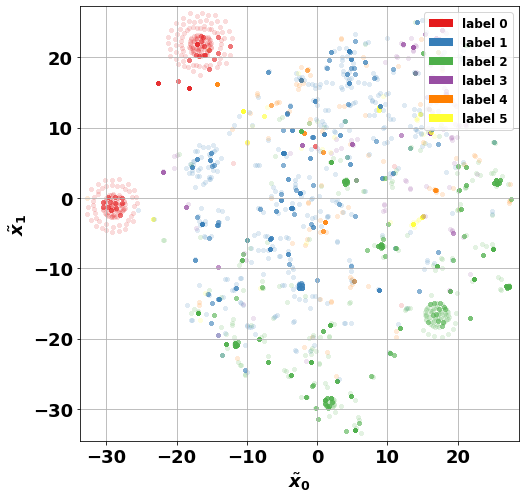

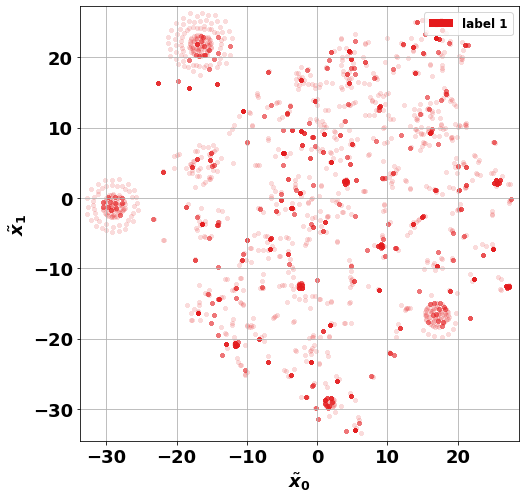

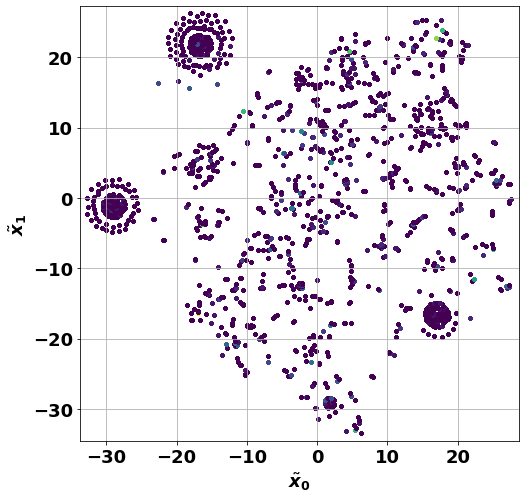

In [64]:
points = pd.DataFrame(tsne[:len(features)], columns=['x0', 'x1'])
points['y'] = ['label {}'.format(l) for l in actual.numpy()]
points['y'] = points['y'].astype("category")

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = 'tab10'
agg = ds.count_cat('y')

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')
plt.legend(handles=artist.get_legend_elements(), prop={'size': 12}, loc='upper right')

plt.savefig('cluster_tsne_space_feuromds_cl_best_actual.png')
plt.show()

points['y'] = ['label {}'.format(l) for l in predicted_reassigned]
points['y'] = points['y'].astype("category")

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = 'tab10'
agg = ds.count_cat('y')

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')
plt.legend(handles=artist.get_legend_elements(), prop={'size': 12}, loc='upper right')

plt.savefig('cluster_tsne_space_feuromds_cl_best_predicted.png')
plt.show()


fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = None
agg = ds.count()

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')

plt.savefig('cluster_tsne_space_feuromds_cl_best_nolbl.png')
plt.show()